# Previsão de preços de ações -- Redes Neurais

### Importar os pacotes e o dataset

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
pip install tensorflow

In [48]:
import tensorflow as tf

In [49]:
from keras.models import Sequential
from keras.layers import Activation, Dense

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
!pip install yfinance --upgrade --no-cache-dir

In [52]:
import yfinance as yf
yf.pdr_override()

In [53]:
codigo = ['PETR4.SA']
petro = yf.Ticker(codigo[0])

In [54]:
# importar os dados do ibovespa 
code = ['BOVA11.SA']
bov = yf.Ticker(code[0])

In [55]:
petro = petro.history(start='2012-01-01', end='2022-07-01')

In [56]:
bov = bov.history(start='2012-01-01', end='2022-07-01')

### Limpar os dados

In [57]:
print(petro['Stock Splits'].unique())
petro['Dividends'].unique()

[0]


array([0.000000e+00, 1.773000e-01, 1.244000e-01, 2.000000e-01,
       3.861700e-01, 9.672000e-01, 5.000000e-02, 1.000000e-01,
       7.165630e-01, 1.949400e-02, 2.009250e-01, 4.219420e-01,
       4.490000e-04, 4.610000e-04, 7.928340e-01, 1.609911e+00,
       3.250487e+00, 2.970249e+00, 3.715490e+00])

In [58]:
petro.drop('Stock Splits',axis=1, inplace=True)

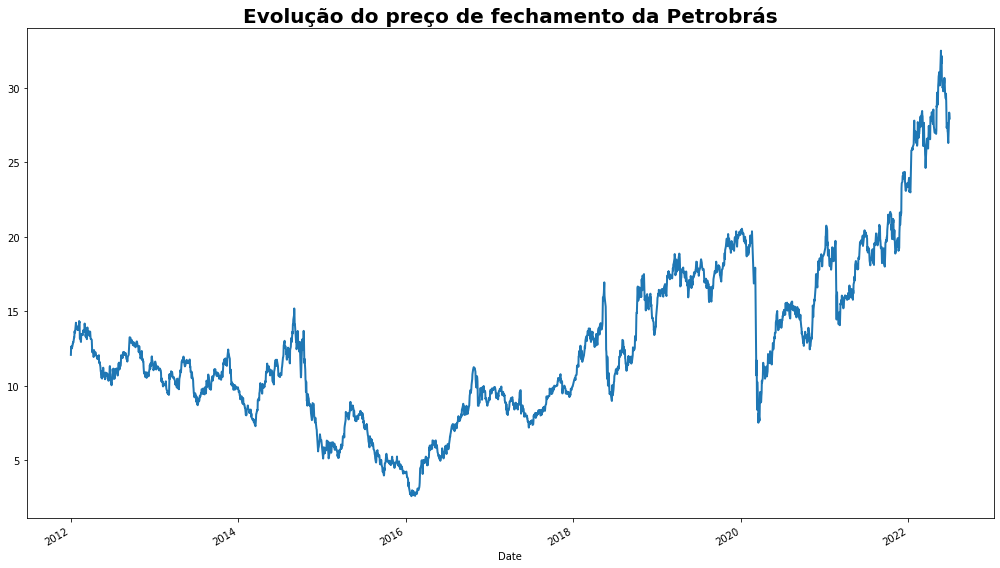

In [59]:
fig, ax = plt.subplots(figsize=(14, 8))
petro['Close'].plot(kind='line', ax=ax, linewidth=2)
ax.set_title('Evolução do preço de fechamento da Petrobrás', fontsize=20, fontweight='bold')
plt.tight_layout()

### Criar novas variáveis

In [60]:
# variável High minus Low price
petro['H-L'] = petro['High'] - petro['Low']

In [61]:
# variável close menos open price
petro['C-O'] = petro['Close'] - petro['Open']

In [62]:
# variável diferença entre os valores mais baixos
petro['low_dif'] = (petro['Low'] - petro['Low'].shift(1))
petro['low_dif'] = petro['low_dif'].fillna(value=0.405418)

In [63]:
# variável diferença entre os valores mais altos
petro['high_dif'] = petro['High'] - petro['High'].shift(1)
petro['high_dif'] = petro['high_dif'].fillna(value=0.263652)

In [64]:
# variáveis de proporção
petro['open_close_ratio'] = petro['Open'] / petro['Close']
petro['high_close_ratio'] = petro['High'] / petro['Close']
petro['low_close_ratio'] = petro['Low'] / petro['Close']

In [65]:
# variável média entre o maior e o menor preço
bov['mean'] = (bov['High'] + bov['Low']) / 2

# definir variável variação percentual da média do índice
bov['perc_mean'] = (bov['mean'].shift(1) - bov['mean']) / bov['mean'].shift(1)
bov['perc_mean'] = bov['perc_mean'].fillna(value=-0.023021)

In [66]:
# transformar as variáveis do ibov para o dataset do modelo
petro['bov_close'] = bov['Close']
petro['bov_mean'] = bov['mean']
petro['perc_mean'] = bov['perc_mean']

### Variável-alvo

In [67]:
petro['tomorrow'] = petro['Close'].shift(-1)

In [68]:
petro['target'] = (petro['tomorrow'] > petro['Close']).astype(int)

In [69]:
# definir features preditivas
predictors = ['Close', 'Volume', 'Open', 'High', 'Low','H-L', 'C-O','low_dif', 'high_dif', 'open_close_ratio',
              'high_close_ratio','low_close_ratio']

### Treino e teste

In [85]:
# conjunto de treinamento e de teste
train = petro.iloc[:-200]
test = petro.iloc[-200:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']

X_train = train[predictors]
X_test = test[predictors]

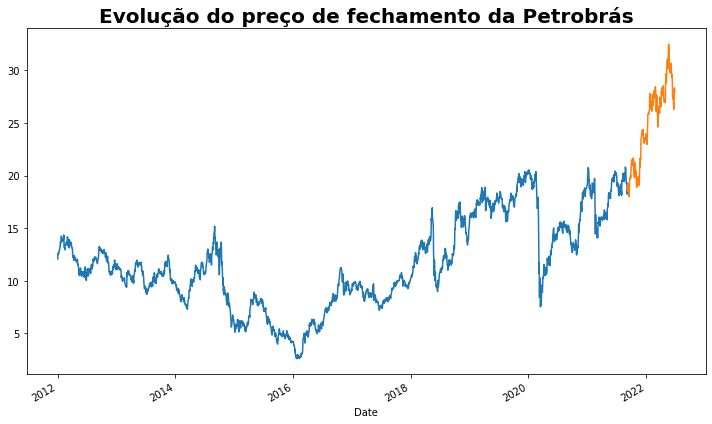

In [86]:
# gráfico com distinção entre dados de treinamento e teste
fig, ax = plt.subplots(figsize=(10, 6))
train['Close'].plot(kind='line', ax=ax)
test['Close'].plot(kind='line', ax=ax)
ax.set_title('Evolução do preço de fechamento da Petrobrás', fontsize=20, fontweight='bold')
plt.tight_layout()

### Criar o modelo e treiná-lo

In [87]:
# criando as redes neurais 
model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(train[predictors].shape[1:])))
model.add(Dense(units=10, activation='relu', input_shape=(train[predictors].shape[1:])))
model.add(Dense(units=6, activation='relu', input_shape=(train[predictors].shape[1:])))
model.add(Dense(1, activation = 'sigmoid'))

In [88]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [89]:
# especificando o otimizador e a função de perda
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 
                                                                     tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [90]:
model.fit(X_train, train['target'], batch_size=10,epochs=200)

Epoch 1/200
241/241 [==============================] - 2s 2ms/step - loss: 17984.9043 - accuracy: 0.5002 - precision_1: 0.5023 - recall_1: 0.4478
Epoch 2/200
241/241 [==============================] - 1s 2ms/step - loss: 130.1006 - accuracy: 0.5056 - precision_1: 0.5072 - recall_1: 0.5224
Epoch 3/200
241/241 [==============================] - 1s 2ms/step - loss: 76.9725 - accuracy: 0.5010 - precision_1: 0.5028 - recall_1: 0.5166
Epoch 4/200
241/241 [==============================] - 1s 2ms/step - loss: 28.5743 - accuracy: 0.5214 - precision_1: 0.5233 - recall_1: 0.5224
Epoch 5/200
241/241 [==============================] - 1s 2ms/step - loss: 7.0375 - accuracy: 0.5065 - precision_1: 0.5082 - recall_1: 0.5149
Epoch 6/200
241/241 [==============================] - 1s 2ms/step - loss: 2.1178 - accuracy: 0.5002 - precision_1: 0.5020 - recall_1: 0.5149
Epoch 7/200
241/241 [==============================] - 1s 2ms/step - loss: 0.7525 - accuracy: 0.4894 - precision_1: 0.4925 - recall_1: 0.573

In [92]:
model.evaluate(X_test, test['target'],verbose=2)

7/7 - 0s - loss: 0.6930 - accuracy: 0.5250 - precision_1: 0.5250 - recall_1: 1.0000 - 32ms/epoch - 5ms/step


[0.6930439472198486, 0.5249999761581421, 0.5249999761581421, 1.0]